In [1]:
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers, losses, models, optimizers
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
rc['font.size']=12
import os
from posydon.grids.psygrid import PSyGrid
from posydon.interpolation.IF_interpolation import BaseIFInterpolator
import warnings
import plotly
import plotly.express as px
import plotly.graph_objs as go
warnings.filterwarnings("ignore", category=DeprecationWarning)
import random

/home/tem7290/.conda/envs/posydon/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/tem7290/.conda/envs/posydon/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#dep

In [2]:
os.chdir("/projects/b1119/eteng/psygrid_dataset")
data = np.load("normalized_logrho_profiles.npy",allow_pickle=True)
sliced = list(data)
data_trunc = random.sample(sliced, k=5000)
data_trunc = np.array(data_trunc)
valid = np.load("normalized_logrho_validation_profiles.npy", allow_pickle=True)

In [4]:
class RhoProf:
    def __init__(self, dataset):
        self.data = dataset
        # will have to make this take in a custom path
        self.model = BaseIFInterpolator(filename = "/home/tem7290/b1119/prs5019/POSYDON/data/POSYDON_data/CO-HeMS/interpolators/linear3c_kNN/grid_0.0142.pkl")

        self.init_unstable = False
        self.init_stable = False
        self.init_initial = False
        self.init_no = False

        self.mass_points = data[0].get('m_arr')
        
    # methods        
    def _vars(self, mt_profs, mt_string, prof_true, final_mass, rho_min, rho_max, rho_minmax, linx, x):
        if mt_profs == []:
            for prof in self.data:
                temp_in = np.transpose([prof.get('m1'), prof.get('m2'), prof.get('p')])
                mt_type = self.model.test_classifier("interpolation_class", np.array([temp_in]))
                if mt_type == mt_string:
                    mt_profs.append(prof)
                    prof_true.append(prof.get('logrho_arr'))
                    final_mass.append(np.log10(prof.get('final_mass')))
                    rho_min.append(prof.get('min_logrho'))
                    rho_max.append(prof.get('max_logrho'))
                    rho_minmax.append([prof.get('min_logrho'), prof.get('max_logrho')])
                    linx.append(temp_in)
                    x.append(np.log10(temp_in))


    def _pca(self, prof_true):
        pca = PCA(n_components=6).fit(prof_true)
        prof_low_unscaled = pca.transform(prof_true)
        sc = np.std(prof_low_unscaled,axis=0)
        prof_low = prof_low_unscaled/sc
        return pca, sc, prof_low
                                      
    def _model(self, x, prof_low):
        model = models.Sequential([
            layers.Dense(15,input_dim=3,activation=None),
            layers.Dense(15,input_dim=15,activation="relu"),
            layers.Dense(15,input_dim=15,activation="relu"),
            layers.Dense(15,input_dim=15,activation="tanh"),
            layers.Dense(10,input_dim=10,activation="tanh"),
            layers.Dense(10,input_dim=10,activation="tanh"),
            layers.Dense(6,activation=None)
        ])
                                      
        loss_mse = losses.MeanSquaredError()
                                      
        model.compile(optimizers.Adam(clipnorm=1),loss=loss_mse)
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
        history = model.fit(x,prof_low,epochs=3000,callbacks=[callback],verbose=0)
        plt.plot(history.history['loss'])
        plt.show()
        return model
                                      
    def _model_mass(self, x, final_mass):
        model_mass = models.Sequential([
            layers.Dense(10,input_dim=3,activation=None),
            layers.Dense(10,input_dim=10,activation='relu'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(1,activation=None)
        ])
                                      
        loss_mse = losses.MeanSquaredError()
        
        model_mass.compile(optimizers.Adam(clipnorm=1),loss="mse")
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
        history = model_mass.fit(x,final_mass,epochs=2000,callbacks=[callback],verbose=0)
        plt.plot(history.history['loss'])
        plt.show()
        return model_mass
                                      
    def _model_rho(self, x, rho_minmax):
        print('entering model rho')
        model_rho = models.Sequential([
            layers.Dense(10,input_dim=3,activation='relu'),
            layers.Dense(10,input_dim=10,activation='relu'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(10,input_dim=10,activation='tanh'),
            layers.Dense(2,activation=None)
        ])

        loss_mse = losses.MeanSquaredError()
        
        model_rho.compile(optimizers.Adam(clipnorm=1),loss="mse")
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
        history = model_rho.fit(x,rho_minmax,epochs=2000,callbacks=[callback],verbose=0)
        plt.plot(history.history['loss'])
        plt.show()
        return model_rho

    def _pred_profiles(self, pca, model, model_mass, model_rho, lin_x, sc):
        x = np.log10(lin_x)
        regress_mass = lambda x: model_mass(x)
        final_log_masses = regress_mass(x)
        final_linear_masses = 10**final_log_masses

        regress_rho = lambda x: model_rho(x)
        min_rho = np.array(regress_rho(x)[:,0])
        max_rho = np.array(regress_rho(x)[:,1])
        min_rho.shape, max_rho.shape = (len(min_rho), 1), (len(max_rho), 1)

        regress = lambda x: model(x)
        scaled_pca_weights = regress(x)
        norm_profiles = pca.inverse_transform(scaled_pca_weights*sc)

        minrho_profiles = min_rho*norm_profiles
        maxrho_profiles = max_rho*norm_profiles

        density_profiles = norm_profiles*(maxrho_profiles-minrho_profiles) + maxrho_profiles
        xcoords = self.mass_points*final_linear_masses[:,np.newaxis]

        return max_rho, xcoords, density_profiles
        
    def _pred_unstable_mt(self, inputs):
        if self.init_unstable == False:
            self.unstable_mt_profs, self.unstable_prof_true, self.unstable_final_mass, self.unstable_rho_min, \
            self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x = [], [], [], [], [], [], [], []
            
            self.unst_val_mt_profs, self.unst_val_prof_true, self.unst_val_final_mass, self.unst_val_rho_min, \
            self.unst_val_rho_max, self.unst_val_rho_minmax, self.unst_val_linx, self.unst_val_x = [], [], [], [], [], [], [], []

            self._vars(self.unstable_mt_profs, 'unstable_MT', self.unstable_prof_true, self.unstable_final_mass,
                       self.unstable_rho_min, self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x)
            
            self._vars(self.unst_val_mt_profs, 'unstable_MT', self.unst_val_prof_true, self.unst_val_final_mass,
                       self.unst_val_rho_min, self.unst_val_rho_max, self.unst_val_rho_minmax, self.unst_val_linx, self.unst_val_x)
            
            self.unstable_mt_profs = np.array(self.unstable_mt_profs)
            self.unstable_prof_true = np.array(self.unstable_prof_true)
            self.unstable_final_mass = np.array(self.unstable_final_mass)
            self.unstable_rho_min = np.array(self.unstable_rho_min)
            self.unstable_rho_max = np.array(self.unstable_rho_max)
            self.unstable_rho_minmax = np.array(self.unstable_rho_minmax)
            self.unstable_linx = np.array(self.unstable_linx)
            self.unstable_x = np.array(self.unstable_x)
            
            self.unst_val_mt_profs = np.array(self.unst_val_mt_profs)
            self.unst_val_prof_true = np.array(self.unst_val_prof_true)
            self.unst_val_final_mass = np.array(self.unst_val_final_mass)
            self.unst_val_rho_min = np.array(self.unst_val_rho_min)
            self.unst_val_rho_max = np.array(self.unst_val_rho_max)
            self.unst_val_rho_minmax = np.array(self.unst_val_rho_minmax)
            self.unst_val_linx = np.array(self.unst_val_linx)
            self.unst_val_x = np.array(self.unst_val_x)
            
            self.unstable_pca, self.unstable_sc, self.unstable_prof_low = self._pca(self.unstable_prof_true)
            self.unst_val_pca, self.unst_val_sc, self.unst_val_prof_low = self._pca(self.unst_val_prof_true)
            self.unstable_model = self._model(self.unstable_x, self.unstable_prof_low)
            self.unstable_model_mass = self._model_mass(self.unstable_x, self.unstable_final_mass)
            self.unstable_model_rho = self._model_rho(self.unstable_x, self.unstable_rho_minmax)
            
            self.init_unstable = True
        
        return self._pred_profiles(self.unstable_pca, self.unstable_model, self.unstable_model_mass, self.unstable_model_rho,\
                                  inputs, self.unstable_sc)
    
    def _pred_stable_mt(self, inputs):
        if self.init_stable == False:
            self.stable_mt_profs, self.stable_prof_true, self.stable_final_mass, self.stable_rho_min, \
            self.stable_rho_max, self.stable_rho_minmax, self.stable_linx, self.stable_x = [], [], [], [], [], [], [], []

            self._vars(self.stable_mt_profs, 'stable_MT', self.stable_prof_true, self.stable_final_mass,
                       self.stable_rho_min, self.stable_rho_max, self.stable_rho_minmax, self.stable_linx, self.stable_x)
            
            self.stable_mt_profs = np.array(self.stable_mt_profs)
            self.stable_prof_true = np.array(self.stable_prof_true)
            self.stable_final_mass = np.array(self.stable_final_mass)
            self.stable_rho_min = np.array(self.stable_rho_min)
            self.stable_rho_max = np.array(self.stable_rho_max)
            self.stable_rho_minmax = np.array(self.stable_rho_minmax)
            self.stable_linx = np.array(self.stable_linx)
            self.stable_x = np.array(self.stable_x)
            
            self.stable_pca, self.stable_sc, self.stable_prof_low = self._pca(self.stable_prof_true)
            self.stable_model = self._model(self.stable_x, self.stable_prof_low)
            self.stable_model_mass = self._model_mass(self.stable_x, self.stable_final_mass)
            self.stable_model_rho = self._model_rho(self.stable_x, self.stable_rho_minmax)
            
            self.init_stable = True
        
        return self._pred_profiles(self.stable_pca, self.stable_model, self.stable_model_mass, self.stable_model_rho,\
                                  inputs, self.stable_sc)
    
    def _pred_initial_mt(self, inputs):
        if self.init_initial == False:
            self.initial_mt_profs, self.initial_prof_true, self.initial_final_mass, self.initial_rho_min, \
            self.initial_rho_max, self.initial_rho_minmax, self.initial_linx, self.initial_x = [], [], [], [], [], [], [], []

            self._vars(self.initial_mt_profs, 'initial_MT', self.initial_prof_true, self.initial_final_mass,
                       self.initial_rho_min, self.initial_rho_max, self.initial_rho_minmax, self.initial_linx, self.initial_x)
            
            self.initial_mt_profs = np.array(self.initial_mt_profs)
            self.initial_prof_true = np.array(self.initial_prof_true)
            self.initial_final_mass = np.array(self.initial_final_mass)
            self.initial_rho_min = np.array(self.initial_rho_min)
            self.initial_rho_max = np.array(self.initial_rho_max)
            self.initial_rho_minmax = np.array(self.initial_rho_minmax)
            self.initial_linx = np.array(self.initial_linx)
            self.initial_x = np.array(self.initial_x)
            
            self.initial_pca, self.initial_sc, self.initial_prof_low = self._pca(self.initial_prof_true)
            self.initial_model = self._model(self.initial_x, self.initial_prof_low)
            self.initial_model_mass = self._model_mass(self.initial_x, self.initial_final_mass)
            self.initial_model_rho = self._model_rho(self.initial_x, self.initial_rho_minmax)
            
            self.init_initial = True
        
        return self._pred_profiles(self.initial_pca, self.initial_model, self.initial_model_mass, self.initial_model_rho,\
                                  inputs, self.initial_sc)
    
    def _pred_no_mt(self, inputs):
        if self.init_no == False:
            self.no_mt_profs, self.no_prof_true, self.no_final_mass, self.no_rho_min, \
            self.no_rho_max, self.no_rho_minmax, self.no_linx, self.no_x = [], [], [], [], [], [], [], []

            self._vars(self.no_mt_profs, 'no_MT', self.no_prof_true, self.no_final_mass,
                       self.no_rho_min, self.no_rho_max, self.no_rho_minmax, self.no_linx, self.no_x)
            
            self.no_mt_profs = np.array(self.no_mt_profs)
            self.no_prof_true = np.array(self.no_prof_true)
            self.no_final_mass = np.array(self.no_final_mass)
            self.no_rho_min = np.array(self.no_rho_min)
            self.no_rho_max = np.array(self.no_rho_max)
            self.no_rho_minmax = np.array(self.no_rho_minmax)
            self.no_linx = np.array(self.no_linx)
            self.no_x = np.array(self.no_x)
            
            self.no_pca, self.no_sc, self.no_prof_low = self._pca(self.no_prof_true)
            self.no_model = self._model(self.no_x, self.no_prof_low)
            self.no_model_mass = self._model_mass(self.no_x, self.no_final_mass)
            self.no_model_rho = self._model_rho(self.no_x, self.no_rho_minmax)
            
            self.init_no = True
        
        return self._pred_profiles(self.no_pca, self.no_model, self.no_model_mass, self.no_model_rho,\
                                  inputs, self.no_sc)
    
    def pred_prof(self, inputs):
        # currently this only works for inputs in [[m1,m2,p]] format. double brackets, one 3d input
        # can adjust to account for more later by returning a list of lists of xcoords, profiles
        # where this function calls the _pred functions through iterating over the inputs and appends the xcoords and profiles
        # to what will be the output
        if len(inputs) == 1:
            mt_type = self.model.test_classifier("interpolation_class", np.array(inputs))
            if mt_type == 'unstable_MT':
                print('unstable')
                return self._pred_unstable_mt(inputs)
            elif mt_type == 'stable_MT':
                print('stable')
                return self._pred_stable_mt(inputs)
            elif mt_type == 'initial_MT':
                print('initial')
                return self._pred_initial_mt(inputs)
            elif mt_type == 'no_MT':
                print('no')
                return self._pred_no_mt(inputs)
        elif len(inputs) > 1:
            unst = []
            st = []
            init = []
            no = []
            for inp in inputs:
                mt_type = self.model.test_classifier("interpolation_class", np.array([inp]))
                if mt_type == 'unstable_MT':
                    unst.append(self._pred_unstable_mt(inp))
                elif mt_type == 'stable_MT':
                    st.append(self._pred_stable_mt(inp))
                elif mt_type == 'initial_MT':
                    init.append(self._pred_initial_mt(inputs))
                elif mt_type == 'no_MT':
                    no.append(self._pred_no_mt(inputs))
                    
            type_return = self.model.test_classifier("interpolation_class", np.array([inputs[0]]))
            if type_return == 'unstable_MT':
                return unst
            elif type_return == 'stable_MT':
                return st
            elif type_return == 'initial_MT':
                return init
            elif type_return == 'no_MT':
                return no
    
    # debugging
    def call_vars(self):
        self.unstable_mt_profs, self.unstable_prof_true, self.unstable_final_mass, self.unstable_rho_min, \
            self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x = [], [], [], [], [], [], [], []
        
        self._vars(self.unstable_mt_profs, 'unstable_MT', self.unstable_prof_true, self.unstable_final_mass,
                       self.unstable_rho_min, self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x)
        
        self.unstable_mt_profs = np.array(self.unstable_mt_profs)
        self.unstable_prof_true = np.array(self.unstable_prof_true)
        self.unstable_final_mass = np.array(self.unstable_final_mass)
        self.unstable_rho_min = np.array(self.unstable_rho_min)
        self.unstable_rho_max = np.array(self.unstable_rho_max)
        self.unstable_rho_minmax = np.array(self.unstable_rho_minmax)
        self.unstable_linx = np.array(self.unstable_linx)
        self.unstable_x = np.array(self.unstable_x)
        
    def print_vars(self):
        return self.unstable_mt_profs, 'unstable_MT', self.unstable_prof_true, self.unstable_final_mass, \
                    self.unstable_rho_min, self.unstable_rho_max, self.unstable_rho_minmax, self.unstable_linx, self.unstable_x
        

unstable
entering model


2022-08-11 11:35:56.315027: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-11 11:35:56.317396: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-11 11:35:56.322722: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-08-11 11:35:56.796962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-11 11:35:56.797719: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


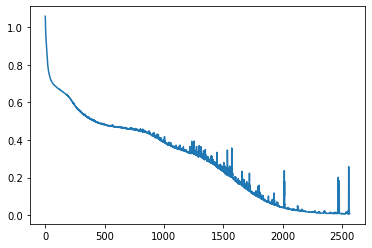

entering model mass


In [ ]:
valid_m1 = [prof.get('m1') for prof in valid]
valid_m2 = [prof.get('m2') for prof in valid]
valid_p = [prof.get('p') for prof in valid]
valid_x = [[valid_m1[i],valid_m2[i],valid_p[i]] for i in range(len(valid_m1))]

model = BaseIFInterpolator(filename = "/home/tem7290/b1119/prs5019/POSYDON/data/POSYDON_data/CO-HeMS/interpolators/linear3c_kNN/grid_0.0142.pkl")
unst_linx = []
st_linx = []
in_linx = []
no_linx = []
unst_m1list = []
unst_m2list = []
unst_plist = []
st_m1list = []
st_m2list = []
st_plist = []
in_m1list = []
in_m2list = []
in_plist = []
no_m1list = []
no_m2list = []
no_plist = []
unst_maxlist = []
st_maxlist = []
in_maxlist = []
no_maxlist = []

glow = RhoProf(data_trunc)
glow.pred_prof([[13, 1, 0.08]])

for inp in valid_x:
    maxrho, xcoords, profiles = glow.pred_prof([inp])
    
    if model.test_classifier("interpolation_class", np.array([inp])) == 'unstable_MT':
        unst_linx.append(inp)
        unst_m1list.append(inp[0])
        unst_m2list.append(inp[1])
        unst_plist.append(inp[2])
        unst_maxlist.append(maxrho)
        
    elif model.test_classifier("interpolation_class", np.array([inp])) == 'stable_MT':
        st_linx.append(inp)
        st_m1list.append(inp[0])
        st_m2list.append(inp[1])
        st_plist.append(inp[2])
        st_maxlist.append(maxrho)
        
    elif model.test_classifier("interpolation_class", np.array([inp])) == 'initial_MT':
        in_linx.append(inp)
        in_m1list.append(inp[0])
        in_m2list.append(inp[1])
        in_plist.append(inp[2])
        in_maxlist.append(maxrho)
        
    elif model.test_classifier("interpolation_class", np.array([inp])) == 'no_MT':
        no_linx.append(inp)
        no_m1list.append(inp[0])
        no_m2list.append(inp[1])
        no_plist.append(inp[2])
        no_maxlist.append(maxrho)

In [ ]:
unst_maxlist[0][0]

In [ ]:
no_maxlist = [no_maxlist[i][0][0] for i in range(len(no_maxlist))]
in_maxlist = [in_maxlist[i][0][0] for i in range(len(in_maxlist))]
st_maxlist = [st_maxlist[i][0][0] for i in range(len(st_maxlist))]
unst_maxlist = [unst_maxlist[i][0][0] for i in range(len(unst_maxlist))]

In [ ]:
# PREDICTIONS BASED ON VALIDATION DATA
fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        x=unst_m1list,
        y=unst_plist,
        z=unst_maxlist,
        title='Max rho predictions'
    )
)
fig.update_layout(scene = dict(
                        xaxis_title = 'm1',
                        yaxis_title = 'p', 
                        zaxis_title = 'max rho'))
fig.show()
# https://www.youtube.com/watch?v=KTDlae_aidQ

In [ ]:
# All 4 predictions
fig = go.Figure(
    data = [
        go.Scatter3d(x=unst_m1list, y=unst_plist, z=unst_maxlist, 
                     name='Unstable', mode='markers'),
        go.Scatter3d(x=st_m1list, y=st_plist, z=st_maxlist, 
                     name='Stable', mode='markers'),
        go.Scatter3d(x=in_m1list, y=in_plist, z=in_maxlist, 
                     name='Initial', mode='markers'),
        go.Scatter3d(x=no_m1list, y=no_plist, z=no_maxlist, 
                     name='No', mode='markers')
    ]
)
fig.show()
# https://stackoverflow.com/questions/71900162/plotly-how-to-plot-multiple-lines-with-different-x-arrays-on-the-same-y-axis

In [ ]:
fig = go.Figure(
    data = [
        go.Scatter3d(x=unst_m1list, y=unst_m2list, z=unst_plist, 
                     name='Unstable', mode='markers', color=unst_maxlist),
        go.Scatter3d(x=st_m1list, y=st_m2list, z=st_plist, 
                     name='Stable', mode='markers', color=st_maxlist),
        go.Scatter3d(x=in_m1list, y=in_m2list, z=in_plist, 
                     name='Initial', mode='markers', color=in_maxlist),
        go.Scatter3d(x=no_m1list, y=no_m2list, z=no_plist, 
                     name='No', mode='markers', color=no_maxlist)
    ]
)
fig.show()